# Preprocessing

In this tutorial we will show how to construct a preprocessing pipeline to "prepare" your recording prior to spike sorting.

In [2]:
from pathlib import Path
import numpy as np

import spikeinterface.full as si
# import spikeinterface.extractors as se
# import spikeinterface.preprocessing as spre
# import spikeinterface.widgets as sw

import matplotlib.pyplot as plt

In [3]:
%matplotlib widget

In [4]:
base_data_folder = Path("/data_local/DataSpikeSorting/data_lyon_cns_2025/raw_datas/")
working_folder = Path("/data_local/DataSpikeSorting/data_lyon_cns_2025/results")

In [5]:
si.set_global_job_kwargs(n_jobs=4)

In [6]:
# load recording
recording_name = "M25_D23_2024-11-11_13-11-10_OF1"

results_folder = working_folder / recording_name

path_to_recording = base_data_folder / recording_name
recording = si.read_openephys(path_to_recording)

Let's first take a look at the "raw" traces:

In [7]:
w = si.plot_traces(recording, order_channel_by_depth=True, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Mmm...it looks very noisy...is there any good signal there? We'll see how preprocessing can drastically change the situation!


The `spikeinterface.preprocessing` module includes a large library of preprocessing functions. We'll only see a few of them, but we encourage you to check out and read what's available!

- [Preprocessing docs](https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html)
- [API reference](https://spikeinterface.readthedocs.io/en/latest/api.html#module-spikeinterface.preprocessing)

In [8]:
# let's order channels by depth, so we don't have to do it all the time
recording = si.depth_order(recording)

In [9]:
# we can also set the "ipywidgets" backend as default
si.set_default_plotter_backend("ipywidgets")

### Step 1: Filtering

Filtering is usually the first step in a preprocessing pipeline. Most acquisition systems record wide-band data. Filtering allow us to focus on the frequency content that contains spikes.

It is important to get rid of low frequency bands (<300 Hz) since they maily contain Local Field Potential (LFP).
Both highpass filter (removing low frequencies) and a bandpass filter (removing low and very high frequencies) can do the job.

They both have pros and cons:
- a highpass filter might let unwanted highpass filters in your signal. However, some argue that a the spike signal is also at relatively high frequencies (>6 kHz) and this might improve spike sorting.
- a bandpass filter might dampen signals from unwanted high-frequency noise (if present), at the expense of cutting out some spike signals

Let's see how to apply and check this preprocessing step

In [10]:
recording_hp = si.highpass_filter(recording)
recording_bp = si.bandpass_filter(recording)

Applying these steps is **extremely fast**! How is it possible that the entire traces have been filtered (twice!) in a split second???
They haven't! 

SpikeInterface uses *lazy* processing, which means that any processing step is applied only when needed. This allow one to construct preprocessing chains, which describe the processing that the traces will go through when retrieved. The `SpikeInterface.Recording` object carries information about what processing steps were applied to it.

In [11]:
recording_hp

HighpassFilterRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                         978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

In [12]:
w = si.plot_traces(
    dict(hp=recording_hp, bp=recording_bp),
)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Step 2a (Neuropixels only): Phase-shift

Some devices have fewer Analog-to-Digital Converters (ADCs) than number of channels. This means that multiple channels are multiplexed, i.e., sequentially sampled, within the same sampling period. Therefore, the channels sampled by the same ADC have a small sub-sampling-period delay between them.
We can correct for these delays using the [`phase_shift`](https://spikeinterface.readthedocs.io/en/latest/api.html#spikeinterface.preprocessing.phase_shift) method.

Phase shift can be applied when the `inter_sample_shift` property is available. This property is automatically loaded for Neuropixels probes.

In [13]:
recording_ps = si.phase_shift(recording_bp)

In [14]:
recording_ps

PhaseShiftRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                     978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

In [15]:
w = si.plot_traces(
    dict(bp=recording_bp, ps=recording_ps),
    time_range=[632.24, 632.25],
)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

The additional alignment, despite being small, can help in further steps, such as denoising, especially in the presence of highly synchronized and probe-wide noise (aka "stripes").

### Step 3: Detecting bad channels

Bad channels can be "broken" electrodes with an abnormally high or low activity. Bad channels can also show up when not the entire probe is inserted in the brain, so that the channels at the top will display different statistics than the rest.

The `detect_bad_channels` implements several methods to detect bad channels. The most advanced methos is designed for needle-like probes and use both PSD and coherence across channels to label channels as "good", "noise" (activity abnormally high), "dead" (activity abnormally low), or "out" (out of brain).
Other methods simply compare the noise level of each channel (as standard deviation or MAD) and if that's to high flags channels as noise.

See [IBL spike sorting paper](https://figshare.com/articles/online_resource/Spike_sorting_pipeline_for_the_International_Brain_Laboratory/19705522/4?file=49783080) for more details.

In [15]:
# spre.detect_bad_channels?

In [16]:
bad_channel_ids, channel_labels = si.detect_bad_channels(recording_ps)

In [19]:
if len(bad_channel_ids) == 0:
    print("No bad channels were found! Lucky us!")

No bad channels were found! Lucky us!


There is also a function to `detect_and_remove_bad_channels` in one go. Since we pre-computed bad channels, we can pass them along.
This is recommended so that out preprocessing "chain" knows that bad channeld detection + removal was applied.

In [20]:
recording_good = si.detect_and_remove_bad_channels(recording_ps, bad_channel_ids=bad_channel_ids, channel_labels=channel_labels)

In [21]:
recording_good

DetectAndRemoveBadChannelsRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                                     978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

### Step 4: Denoising

After removing bad channels, we can try to further reduce noise in the traces, especially the "common mode" noise (e.g., noise shared across all/many channels).
The source of such noise is usually extrinsic (for example a lamp in your rig!) and it causes those stripes that we've seen in the plots.

We have two ways to remove these stripes, again, with pros and cons:

- Common Median Reference (CMR): CMR is very widely used and very simple! For every sample, we remove the median of all channels. If noise is shared across all channels, then it will be removed by these operation. The downside is that if some channels don't experience the shared noise, an artifact could be introduced.
- Highpass Spatial Filtering: this step instead performs a highpass filter in space. You can imagine vertical stripes as low frequency (DC) in the space dimension. The upside of this method is that it can handle partial noise shared on large subset of channels. The downside is that it can also dampen spike signals, especially when they are shared across many channels.

In [22]:
recording_cmr = si.common_reference(recording_good)
recording_hps = si.highpass_spatial_filter(recording_good)

In [23]:
recording_cmr

CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                          978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

In [24]:
w = si.plot_traces(
    dict(bp=recording_bp, cmr=recording_cmr, hps=recording_hps),
    time_range=[632.24, 632.25],
)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Step 5: Motion estimation and assessment

Shank-like probes, when implanted *in vivo* and mostly in acute settings, can experience "drift", aka relative motion between the probe and the neurons.

This makes waveforms change (A), which is a nightmare for spike sorting (since they rely on similarity between waveforms...). Some sorters can partially correct for motion, but it's been showed that when motion is present, spike sorting results are strongly affected, no matter the correction (see [Garcia et. al 2024](https://www.eneuro.org/content/11/2/ENEURO.0229-23.2023.abstract) for more details).

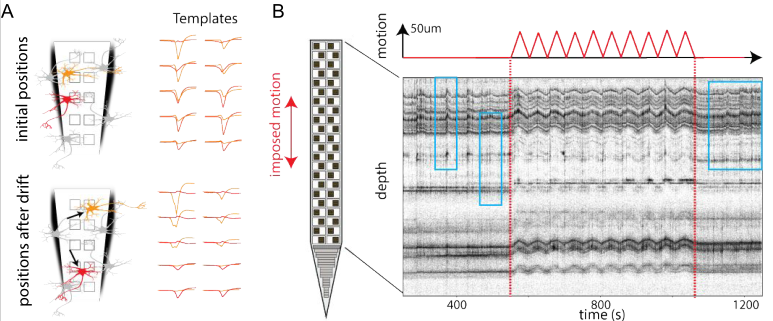


What can we do? At the very least, we should assess whether motion is a problem for our dataset.


The `spikeinterface.preprocessing` module has a convenient [`compute_motion`](https://spikeinterface.readthedocs.io/en/latest/api.html#spikeinterface.preprocessing.compute_motion) function, which comes with several "presets".

In [25]:
si.get_motion_presets()

['dredge',
 'medicine',
 'dredge_fast',
 'nonrigid_accurate',
 'nonrigid_fast_and_accurate',
 'rigid_fast',
 'kilosort_like']

In [26]:
motion_folder = results_folder / "motion_dredge"

In [27]:
si.set_global_job_kwargs(n_jobs=36, chunk_duration="1s", progress_bar=True)
if motion_folder.is_dir():
    print("Motion loaded from disk")
    motion_info_dr = si.load_motion_info(motion_folder)
    motion_dr = motion_info_dr["motion"]
else:
    motion_dr, motion_info_dr = si.compute_motion(
        recording=recording_cmr,
        preset="dredge_fast",
        output_motion_info=True,
    )
    si.save_motion_info(motion_info_dr, folder=motion_folder)

Motion loaded from disk


In [28]:
motion_dr

Motion non-rigid - 7 spatial bins - interval 1.0s - 1 segments

In [28]:
motion_info_dr.keys()

dict_keys(['parameters', 'run_times', 'peaks', 'peak_locations', 'motion'])

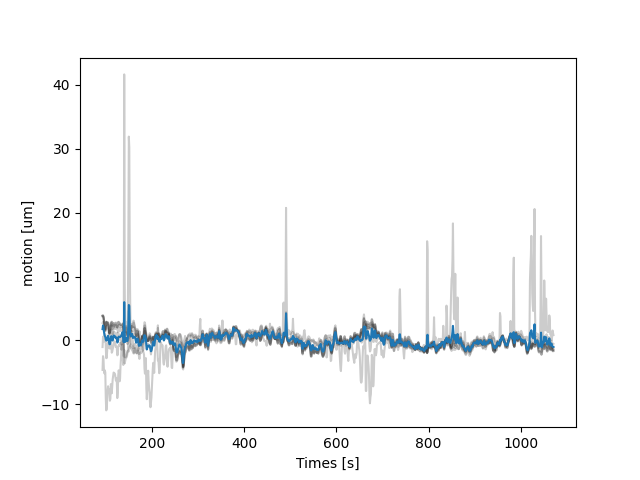

In [29]:
# plot motion and rastermap
_ = si.plot_motion(motion_dr, backend="matplotlib")

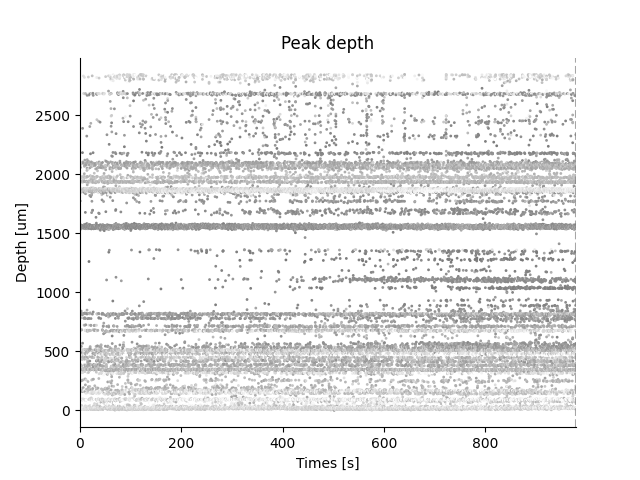

In [30]:
_ = si.plot_drift_raster_map(
    peaks=motion_info_dr["peaks"],
    peak_locations=motion_info_dr["peak_locations"],
    recording=recording_cmr,
    cmap="Greys_r",
    scatter_decimate=5,
    backend="matplotlib"
)

> **_NOTE:_**  When dealing with *in vitro* preparations, motion is normally not an issue, since cells/slices etc. won't move much during a recording session. Motion can still happen at longer timescales, due to cell migration, reorganization, or sample movement.

### Step 6: Save preprocessed recording

Now that we have finalized our *lazy* preprocessing chain, we can save a preprocessed version to a binary file (or a [Zarr](https://zarr.readthedocs.io/en/stable/) folder). Downstream steps, like spike sorting and postprocessing, will need access to the preprocessed traces. In order to avoid preprocessing "on-the-fly" several times, we can dump the preprocessed data to a file.

This operation (and many others) can be performed in parallel, using multiple CPUs to crunch chunks of the traces. All the parallel operations are controlled by the `job_kwargs`. Let's take a look at them and set them globally:

In [31]:
recording_preprocessed = recording_cmr

In [32]:

recording_cmr


CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                          978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

In [32]:
si.get_global_job_kwargs()

{'pool_engine': 'process',
 'n_jobs': 36,
 'chunk_duration': '1s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_worker': 1}

In [33]:
si.set_global_job_kwargs(chunk_duration="2s")

In [34]:
si.get_global_job_kwargs()

{'pool_engine': 'process',
 'n_jobs': 36,
 'chunk_duration': '2s',
 'progress_bar': True,
 'mp_context': None,
 'max_threads_per_worker': 1}

In [35]:
recording_preprocessed

CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                          978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

In [36]:
preprocessed_bin_folder = results_folder / "preprocessed"

if preprocessed_bin_folder.is_dir():
    print("Preprocessed binary recording loaded from disk")
    recording_binary = si.load(preprocessed_bin_folder)
else:
    # save to binary: fast!
    recording_binary = recording_preprocessed.save(folder=preprocessed_bin_folder, format="binary")
recording_binary

write_binary_recording 
engine=process - n_jobs=36 - samples_per_chunk=60,000 - chunk_memory=43.95 MiB - total_memory=1.54 GiB - chunk_duration=2.00s


write_binary_recording (workers: 36 processes):   0%|          | 0/490 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 29,363,947 samples 
                       978.80s (16.31 minutes) - int16 dtype - 21.00 GiB

In [ ]:
preprocessed_zarr_folder = results_folder / "preprocessed.zarr"

if preprocessed_zarr_folder.is_dir():
    print("Preprocessed zarr recording loaded from disk")
    recording_binary = si.load(preprocessed_zarr_folder)
else:
    # save to Zarr (and compress): slower (at retrieving traces), but saves disk space (for persistent storage!)
    recording_zarr = recording_preprocessed.save(folder=preprocessed_zarr_folder, format="zarr")
recording_zarr

In [39]:
def get_folder_size_gb(path="."):
    import os
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # Skip if it's a broken symlink
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size / (1024 ** 3)

In [40]:
size_binary = get_folder_size_gb(path=preprocessed_bin_folder)
size_zarr = get_folder_size_gb(path=preprocessed_zarr_folder)
print(f"Size of preprocessed binary folder: {size_binary:.2f} GB")
print(f"Size of preprocessed Zarr folder: {size_zarr:.2f} GB")

Size of preprocessed binary folder: 21.00 GB
Size of preprocessed Zarr folder: 0.00 GB
